<a href="https://colab.research.google.com/github/gagan3012/notebooks/blob/master/MFCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook for MFCC feature extraction demo

Getting the data

In [1]:
!wget https://www.openslr.org/resources/12/test-clean.tar.gz

--2022-01-23 03:59:53--  https://www.openslr.org/resources/12/test-clean.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://us.openslr.org/resources/12/test-clean.tar.gz [following]
--2022-01-23 03:59:53--  http://us.openslr.org/resources/12/test-clean.tar.gz
Resolving us.openslr.org (us.openslr.org)... 46.101.158.64
Connecting to us.openslr.org (us.openslr.org)|46.101.158.64|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 346663984 (331M) [application/x-gzip]
Saving to: ‘test-clean.tar.gz’

test-clean.tar.gz   100%[===================>] 330.60M  26.5MB/s    in 13s     

2022-01-23 04:00:07 (24.5 MB/s) - ‘test-clean.tar.gz’ saved [346663984/346663984]



Installing required Libraries

In [2]:
!pip install audiomentations

In [3]:
import os
import math
import IPython
import torch
import torchaudio
from audiomentations import Compose, Normalize, AddGaussianSNR, AddGaussianNoise, AddImpulseResponse, AddShortNoises, AddBackgroundNoise
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches
import librosa
import torch.nn.functional as F
import seaborn as sns
import numpy as np
#torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
torchaudio.set_audio_backend("sox_io")

DATA_PATH = ''
plt.rcParams['figure.dpi'] = 160
n_fft = 512

if not os.path.exists(os.path.join(DATA_PATH, 'LibriSpeech')):
    torchaudio.datasets.LIBRISPEECH(DATA_PATH, url='test-clean', download=True)

Selecting test files 

In [4]:
test_file_path = os.path.join(DATA_PATH, "LibriSpeech/test-clean/121/127105/121-127105-0036.flac")
signal, sample_rate = torchaudio.load(test_file_path)
print(vars(torchaudio.info(test_file_path)))

signals1 = []
for i in range(1,5):
    test_file_path = os.path.join(DATA_PATH, "LibriSpeech/test-clean/121/127105/121-127105-00{:02d}.flac".format(int(36/i)))
    signal1, _ = torchaudio.load(test_file_path)
    signals1.append(signal1)

signals2 = []
for i in range(1,5):
    test_file_path = os.path.join(DATA_PATH, "LibriSpeech/test-clean/260/123286/260-123286-00{:02d}.flac".format(int(31/i)))
    signal1, _ = torchaudio.load(test_file_path)
    signals2.append(signal1)
    
signals3 = []
for i in range(1,5):
    test_file_path = os.path.join(DATA_PATH, "LibriSpeech/test-clean/7127/75946/7127-75946-00{:02d}.flac".format(int(29/i)))
    signal1, _ = torchaudio.load(test_file_path)
    signals3.append(signal1)

{'sample_rate': 16000, 'num_frames': 66400, 'num_channels': 1, 'bits_per_sample': 16, 'encoding': 'FLAC'}


In [6]:
import torch.nn.functional as F
class PreEmphasis(torch.nn.Module):  # pylint: disable=abstract-method
    def __init__(self, coef: float = 0.97):
        super().__init__()
        self.coef = coef
        # make kernel
        # In pytorch, the convolution operation uses cross-correlation. So, filter is flipped.
        self.register_buffer(
            'flipped_filter', torch.FloatTensor([-self.coef, 1.]).unsqueeze(0).unsqueeze(0)
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        assert len(input.size()) == 2, 'The number of dimensions of input tensor must be 2!'
        # reflect padding to match lengths of in/out
        input = input.unsqueeze(1)
        input = F.pad(input, (1, 0), 'reflect')  # type: ignore
        return F.conv1d(input, self.flipped_filter).squeeze(1)  # type: ignore

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  "At least one mel filterbank has all zero values. "


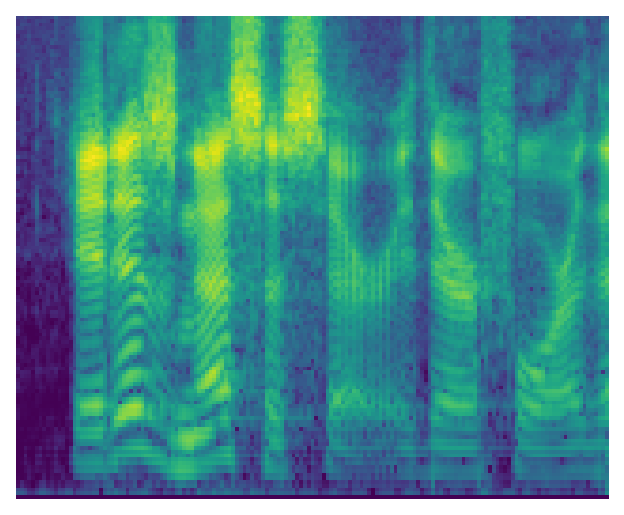

In [7]:
n_mels = 128
n_fft = 512

for i, s in enumerate(signals1):
    s = PreEmphasis()(s)
    mel_spectro = torchaudio.transforms.MelSpectrogram(n_mels=n_mels, n_fft=n_fft, win_length=400, hop_length=160, window_fn=torch.hamming_window)(s[:,5000:30000]) + 1e-6
    plt.axis('off')
    plt.imshow(mel_spectro.log2()[0,:,:], cmap='viridis')
    plt.gca().invert_yaxis()
    plt.savefig('spkr1-mel{}.pdf'.format(i), bbox_inches='tight', transparent='True', pad_inches=0)
    
for i, s in enumerate(signals2):
    s = PreEmphasis()(s)
    mel_spectro = torchaudio.transforms.MelSpectrogram(n_mels=n_mels, n_fft=n_fft, win_length=400, hop_length=160, window_fn=torch.hamming_window)(s[:,5000:30000]) + 1e-6
    plt.axis('off')
    plt.imshow(mel_spectro.log2()[0,:,:], cmap='viridis')
    plt.gca().invert_yaxis()
    plt.savefig('spkr2-mel{}.pdf'.format(i), bbox_inches='tight', transparent='True', pad_inches=0)

for i, s in enumerate(signals3):
    s = PreEmphasis()(s)
    mel_spectro = torchaudio.transforms.MelSpectrogram(n_mels=n_mels, n_fft=n_fft, win_length=400, hop_length=160, window_fn=torch.hamming_window)(s[:,5000:30000]) + 1e-6
    plt.axis('off')
    plt.imshow(mel_spectro.log2()[0,:,:], cmap='viridis')
    plt.gca().invert_yaxis()
    plt.savefig('spkr3-mel{}.pdf'.format(i), bbox_inches='tight', transparent='True', pad_inches=0)

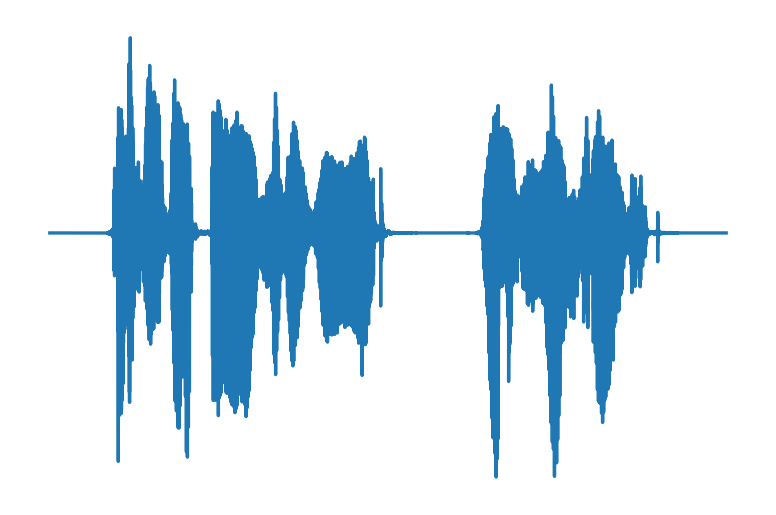

In [8]:
plt.plot(signal.t().detach())
plt.axis('off')
plt.savefig('waveform.pdf')
IPython.display.Audio(test_file_path)

Adding Gaussian Noise

/usr/local/lib/python3.7/dist-packages/audiomentations/augmentations/transforms.py:273: UserWarning: You use legacy min_SNR and max_SNR parameters in AddGaussianSNR. We highly recommend to use min_snr_in_db and max_snr_in_db parameters instead. To migrate from legacy parameters to new parameters, use the following conversion formulas: 
min_snr_in_db = -20 * math.log10(max_SNR)
max_snr_in_db = -20 * math.log10(min_SNR)
  "You use legacy min_SNR and max_SNR parameters in AddGaussianSNR."


-1.0 0.7792815


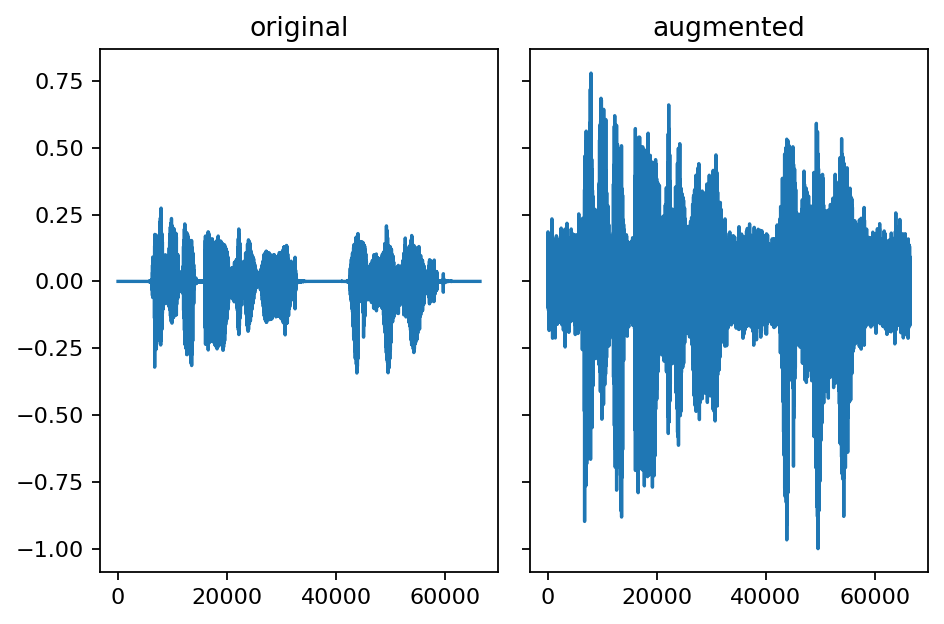

In [10]:
augment = Compose([
    AddGaussianSNR(min_SNR=0.5, max_SNR=0.5, p=1.0),
    #AddShortNoises(os.path.join(DATA_PATH, 'RIRS_NOISES', 'pointsource_noises'), max_snr_in_db=80, p=1.0),
    #AddBackgroundNoise(os.path.join(DATA_PATH, 'RIRS_NOISES', 'pointsource_noises'), p=1.0),
    #AddImpulseResponse(os.path.join(DATA_PATH, 'RIRS_NOISES', 'simulated_rirs'), leave_length_unchanged=True, p=1.0),
    Normalize()
])
augmented_np = augment(samples=signal.t().numpy().flatten(), sample_rate=sample_rate)

print(np.min(augmented_np), np.max(augmented_np))

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

axes[0].set_title('original')
axes[0].plot(signal.t().detach())

axes[1].set_title('augmented')
axes[1].plot(augmented_np)

fig.tight_layout()

Plotting spectrogram

torch.Size([1, 257, 416])


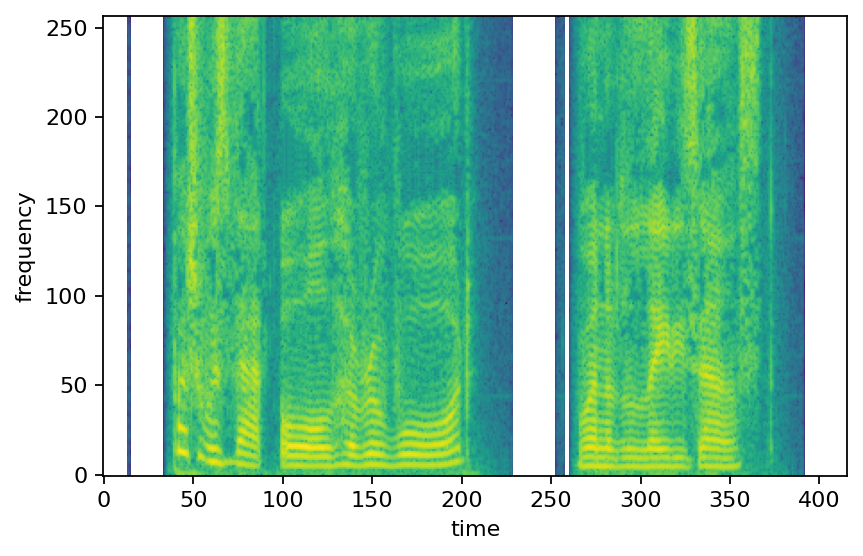

In [11]:
spectro = torchaudio.transforms.Spectrogram(n_fft=n_fft, win_length=400, hop_length=160,
                                            window_fn=torch.hamming_window)(signal)
print(spectro.shape)

plt.imshow(spectro.log2()[0,:,:], cmap='viridis')
plt.ylabel('frequency')
plt.xlabel('time')
plt.gca().invert_yaxis()

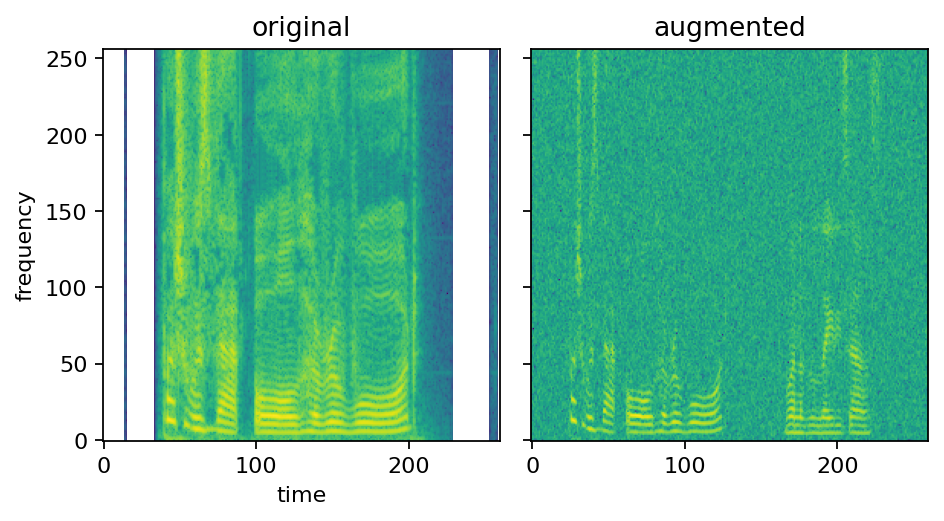

In [12]:
augmented = torch.from_numpy(augmented_np).view(1,-1)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

axes[0].set(xlabel='time', ylabel='frequency')
axes[0].set_title('original')
axes[0].imshow(spectro.log2()[0,:,:], cmap='viridis')
axes[0].invert_yaxis()

spectro_aug = torchaudio.transforms.Spectrogram(n_fft=n_fft)(augmented)
axes[1].set_title('augmented')
axes[1].imshow(spectro_aug.log2()[0,:,:], cmap='viridis')
axes[1].invert_yaxis()
fig.tight_layout()

Plotting the MFCC

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


torch.Size([1, 128, 333])


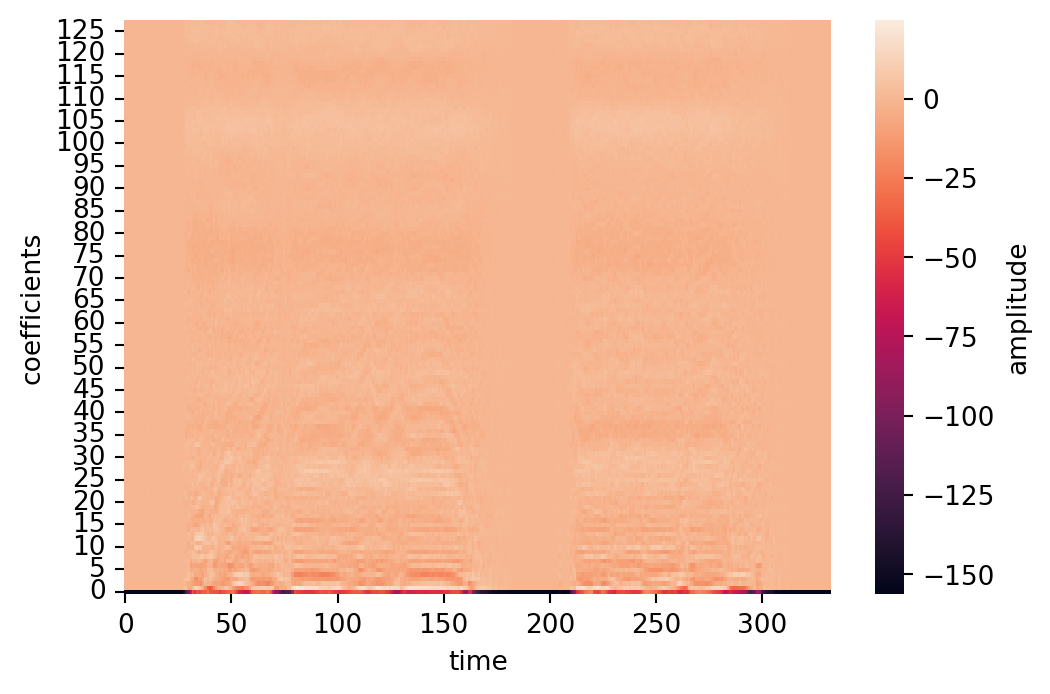

In [13]:
mfcc = torchaudio.transforms.MFCC(sample_rate=sample_rate, n_mfcc=n_mels, log_mels=True)(signal)
print(mfcc.shape)

plt.figure(dpi=190)
ax = sns.heatmap(mfcc[0,:,:], xticklabels=50, yticklabels=5, cbar_kws={'label': 'amplitude'})
ax.set(xlabel='time', ylabel='coefficients')
plt.gca().invert_yaxis()
plt.show()

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


<Figure size 1140x760 with 0 Axes>

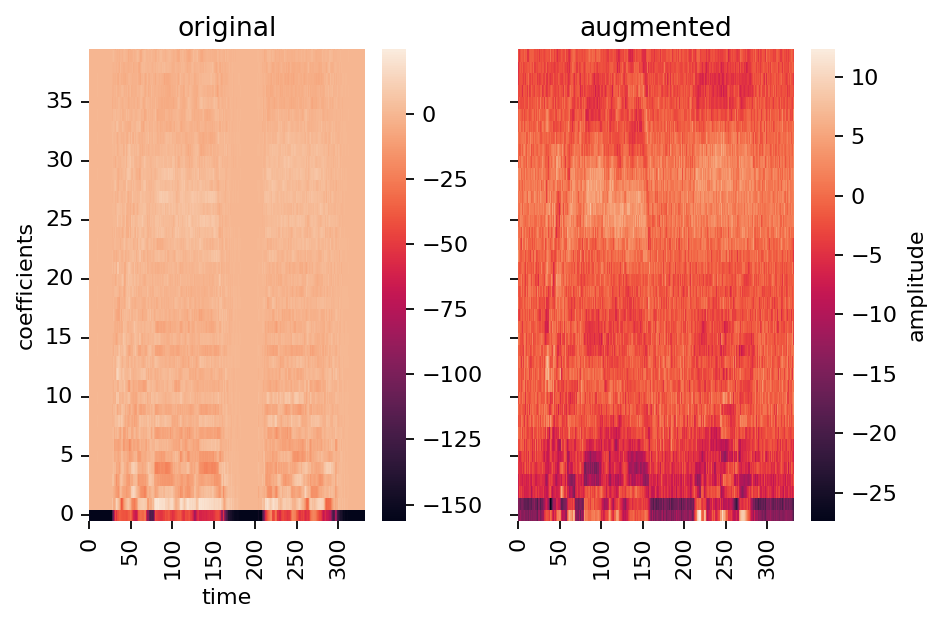

In [14]:
mfcc_aug = torchaudio.transforms.MFCC(sample_rate=sample_rate, log_mels=True)(augmented)

plt.figure(dpi=190)
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

sns.heatmap(mfcc[0,:,:], ax=axes[0], xticklabels=50, yticklabels=5)
axes[0].set(xlabel='time', ylabel='coefficients')
axes[0].set_title('original')
axes[0].invert_yaxis()

axes[1].set_title('augmented')
sns.heatmap(mfcc_aug[0,:,:], ax=axes[1], xticklabels=50, yticklabels=5, cbar_kws={'label': 'amplitude'})
axes[1].invert_yaxis()
fig.tight_layout()
plt.show()